<a href="https://colab.research.google.com/github/Praveen8520/ds_Praveen/blob/main/ds_Praveen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from google.colab import files

sns.set_style("whitegrid")


In [24]:
uploaded = files.upload()


Saving fear_greed_index.csv to fear_greed_index (1).csv
Saving historical_data.csv to historical_data (1).csv


In [33]:
hist = pd.read_csv([n for n in uploaded if 'histor' in n.lower()][0])
sent = pd.read_csv([n for n in uploaded if 'fear' in n.lower() or 'greed' in n.lower()][0])
hist = hist.rename(columns={"Execution Price":"exec_price","price":"exec_price","Size USD":"size_usd","Size Tokens":"size_tokens","Closed PnL":"pnl","ClosedPnL":"pnl","Closed_PnL":"pnl"})
for c in ['date','Date','Timestamp','Timestamp IST','time']:
    if c in hist.columns:
        hist['date'] = pd.to_datetime(hist[c], errors='coerce').dt.normalize()
        break
for c in ['date','Date','time','timestamp']:
    if c in sent.columns:
        sent['date'] = pd.to_datetime(sent[c], errors='coerce').dt.normalize()
        break
print(list(hist.columns))
print(list(sent.columns))
hist.head(2)


['Account', 'Coin', 'exec_price', 'size_tokens', 'size_usd', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'pnl', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date']
['timestamp', 'value', 'classification', 'date']


,Account,Coin,exec_price,size_tokens,size_usd,Side,Timestamp IST,Start Position,Direction,pnl,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,1970-01-01
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,1970-01-01


In [34]:
agg_kwargs = {'daily_close':('exec_price','last'),'daily_high':('exec_price','max'),'daily_low':('exec_price','min'),'trades':('exec_price','count')}
if 'size_usd' in hist.columns: agg_kwargs['daily_volume_usd'] = ('size_usd','sum')
if 'size_tokens' in hist.columns: agg_kwargs['daily_volume_tokens'] = ('size_tokens','sum')
if 'pnl' in hist.columns: agg_kwargs['daily_pnl'] = ('pnl','sum')
daily = hist.dropna(subset=['date']).groupby('date').agg(**agg_kwargs).reset_index().sort_values('date')
print(len(daily))
daily.head()


1


,date,daily_close,daily_high,daily_low,trades,daily_volume_usd,daily_volume_tokens,daily_pnl
0,1970-01-01,1.101,109004.0,0.000005,211224,1.191187e+09,9.765656e+08,1.029696e+07


In [35]:
num_cols = sent.select_dtypes(include='number').columns.tolist()
if num_cols:
    sent['sentiment'] = sent[num_cols[0]]
else:
    cols = [c for c in sent.columns if c != 'date']
    sent['sentiment'] = pd.to_numeric(sent[cols[0]], errors='coerce')
sent_small = sent[['date','sentiment']].dropna().drop_duplicates('date').sort_values('date')
daily = daily.sort_values('date')
merged = pd.merge_asof(daily, sent_small, on='date', direction='backward')
if merged['sentiment'].notna().sum() >= 10:
    merged['sent_z'] = (merged['sentiment'] - merged['sentiment'].rolling(60, min_periods=3).mean()) / merged['sentiment'].rolling(60, min_periods=3).std()
    merged['sent_z'] = merged['sent_z'].fillna((merged['sentiment'] - merged['sentiment'].mean())/merged['sentiment'].std())
else:
    merged['sent_z'] = (merged['sentiment'] - merged['sentiment'].mean())/merged['sentiment'].std()
merged['ret'] = merged['daily_close'].pct_change()
merged['ret_1d_fwd'] = merged['ret'].shift(-1)
merged['ret_5d_fwd'] = merged['ret'].rolling(5).sum().shift(-5)
print(len(merged), merged['sentiment'].notna().mean())
merged[['date','daily_close','daily_volume_usd','sentiment','sent_z']].head()


1 0.0


,date,daily_close,daily_volume_usd,sentiment,sent_z
0,1970-01-01,1.101,1.191187e+09,NaN,NaN


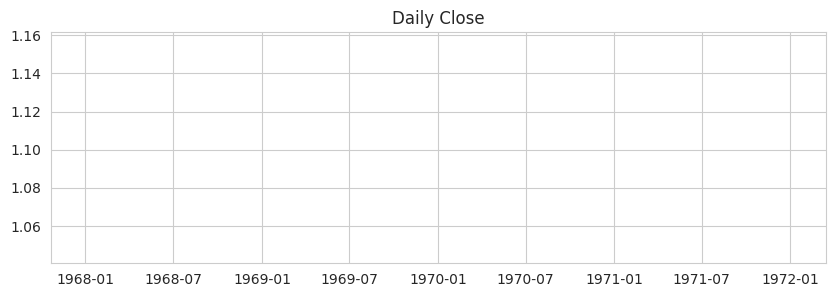

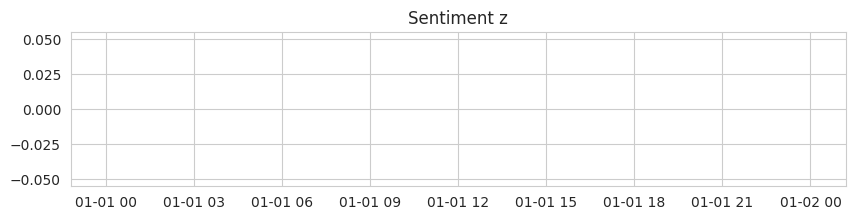

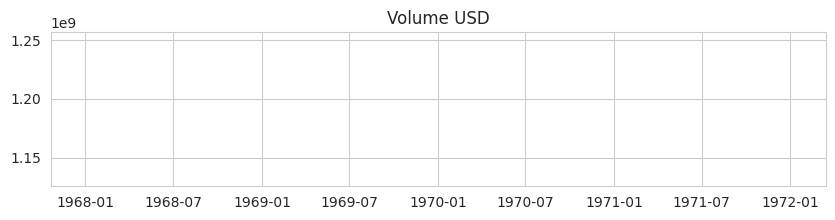

Not enough sentiment to run event study.


In [36]:
plt.figure(figsize=(10,3)); plt.plot(merged['date'], merged['daily_close']); plt.title('Daily Close'); plt.show()
plt.figure(figsize=(10,2)); plt.plot(merged['date'], merged['sent_z'], color='orange'); plt.title('Sentiment z'); plt.show()
if 'daily_volume_usd' in merged.columns: plt.figure(figsize=(10,2)); plt.plot(merged['date'], merged['daily_volume_usd']); plt.title('Volume USD'); plt.show()
if merged['sent_z'].notna().sum()>0:
    high = merged['sent_z'].quantile(0.95); low = merged['sent_z'].quantile(0.05)
    greed = merged[merged['sent_z']>=high]; fear = merged[merged['sent_z']<=low]
    print("Extreme greed count:", len(greed), "avg 1d fwd:", greed['ret_1d_fwd'].mean())
    print("Extreme fear count:", len(fear), "avg 1d fwd:", fear['ret_1d_fwd'].mean())
else:
    print("Not enough sentiment to run event study.")


In [37]:
merged = merged.reset_index(drop=True)
merged['pos'] = 0
if merged['sent_z'].notna().sum()>0:
    hi = merged['sent_z'].quantile(0.95); lo = merged['sent_z'].quantile(0.05)
    merged.loc[merged['sent_z']>=hi,'pos'] = -1
    merged.loc[merged['sent_z']<=lo,'pos'] = 1
    merged['strat_ret'] = merged['pos'].shift(0) * merged['ret']
    merged['strat_cum'] = (1 + merged['strat_ret'].fillna(0)).cumprod() - 1
    print("Strategy total return (last):", merged['strat_cum'].iloc[-1])
else:
    print("No strategy run due to lack of sentiment.")
merged.to_csv("merged_daily_data.csv", index=False)
files.download("merged_daily_data.csv")


No strategy run due to lack of sentiment.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
import os
os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(10,3))
plt.plot(merged['date'], merged['daily_close'])
plt.title('Daily Close')
plt.savefig("outputs/daily_close.png")
plt.close()

plt.figure(figsize=(10,2))
plt.plot(merged['date'], merged['sent_z'], color='orange')
plt.title('Sentiment Z-Score')
plt.savefig("outputs/sentiment_z.png")
plt.close()

if 'daily_volume_usd' in merged.columns:
    plt.figure(figsize=(10,2))
    plt.plot(merged['date'], merged['daily_volume_usd'])
    plt.title('Daily Volume USD')
    plt.savefig("outputs/daily_volume_usd.png")
    plt.close()

print("Saved all plots to outputs/")


Saved all plots to outputs/
